In [4]:
import torch
import numpy as np
import models.networks as nets
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [5]:
model = nets.cDCGANGenerator(input_nz=128, output_nc=1, ngf=32)
# Load the model
model.load_state_dict(torch.load('checkpoints/mnistUniqueFashionUniform_UAGAN_10D/latest_net_G.pth'))
model.eval()

cDCGANGenerator(
  (deconv1_1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (deconv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1_2): ConvTranspose2d(10, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (deconv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

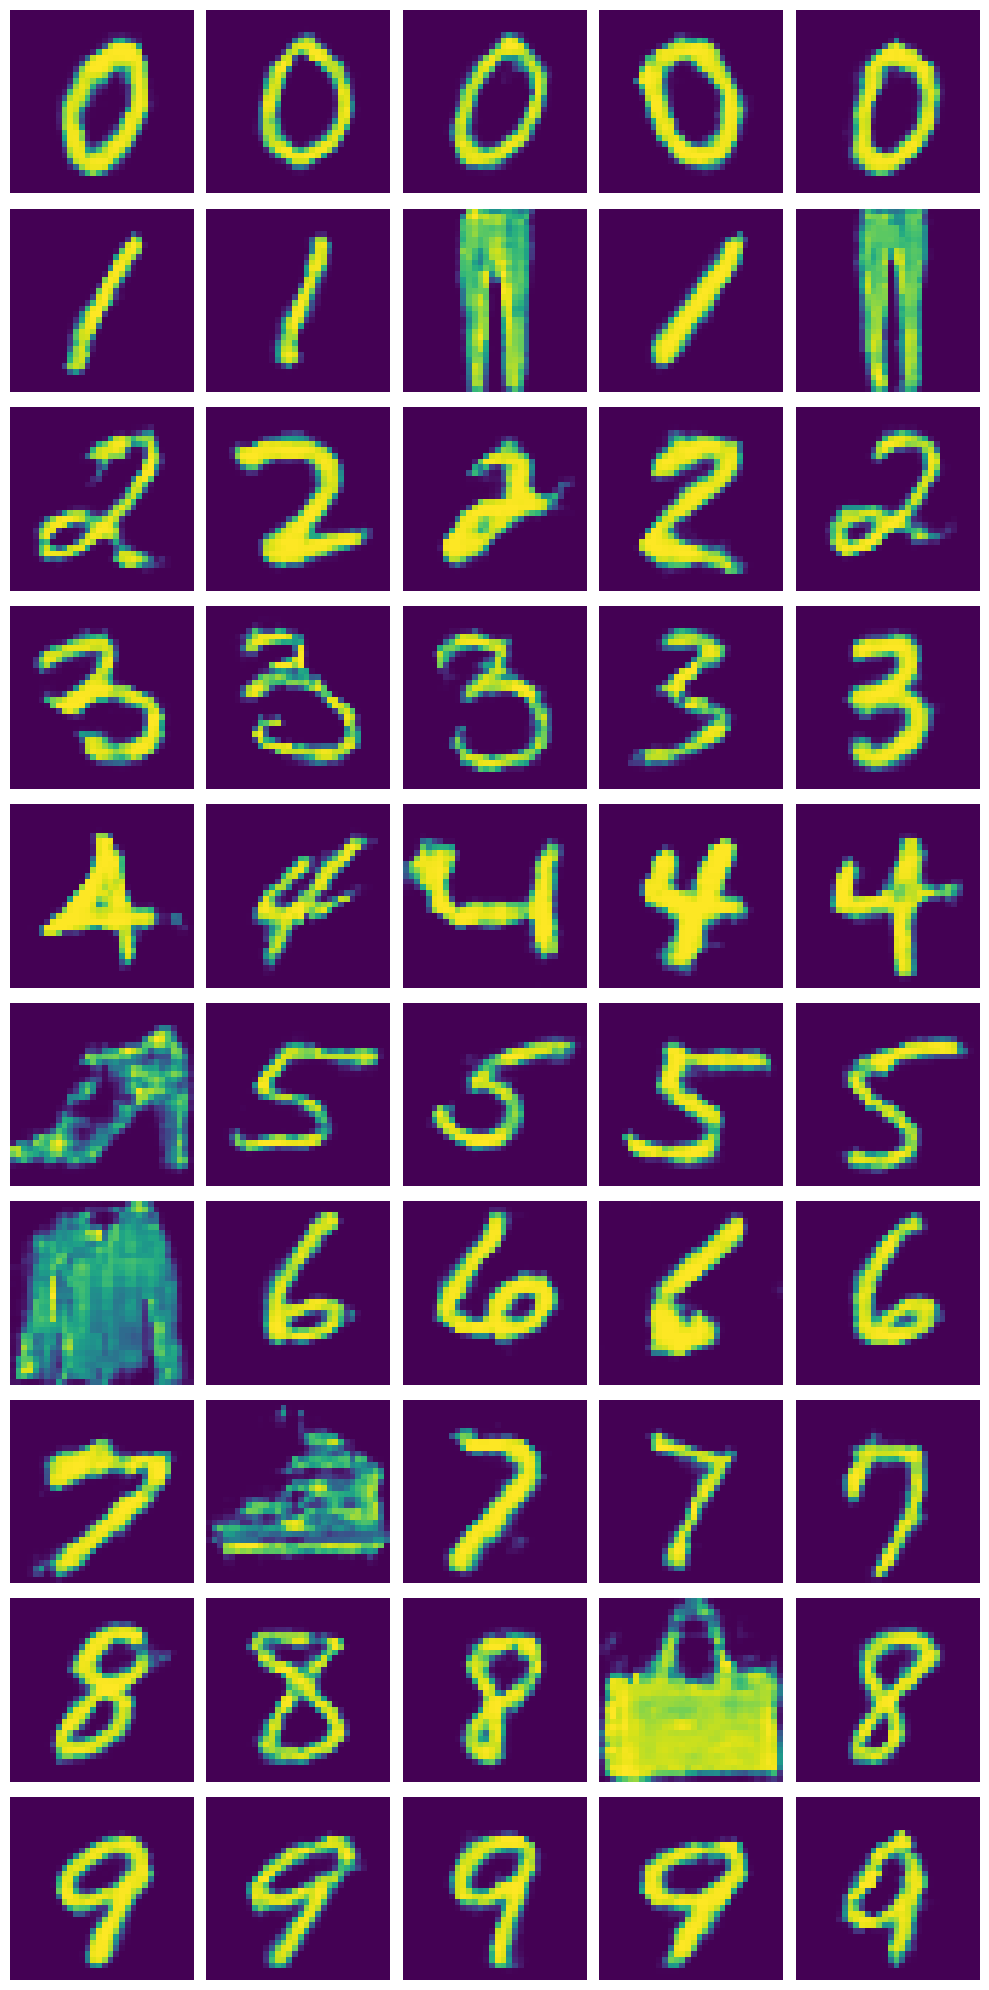

In [6]:
# parameters
n_classes  = 10
n_per_cls  = 5
latent_dim = 128

# 1) sample one batch of noise of size 10*5
batch_size = n_classes * n_per_cls
z = torch.randn(batch_size, latent_dim, 1, 1)

# 2) build labels: [0,0,0,0,0, 1,1,1,1,1, 2,2,...,9,9]
labels = torch.arange(n_classes).unsqueeze(1).repeat(1, n_per_cls).view(-1)

# 3) one-hot encode and reshape to (B,10,1,1)
labels_onehot = F.one_hot(labels, num_classes=n_classes).float().view(batch_size, n_classes, 1, 1)

# 4) generate images
model.eval()
with torch.no_grad():
    fake_images = model(z, labels_onehot)  # (50, C, H, W)

# 5) plot in a 10 x 5 grid
fake_np = fake_images.cpu().numpy()
fig, axes = plt.subplots(n_classes, n_per_cls, figsize=(n_per_cls*2, n_classes*2))

for cls in range(n_classes):
    for i in range(n_per_cls):
        idx = cls * n_per_cls + i
        img = fake_np[idx].transpose(1,2,0)  # (H,W,C)
        img = (img + 1) / 2                  # rescale from [-1,1] → [0,1]
        axes[cls, i].imshow(np.clip(img, 0, 1))
        axes[cls, i].axis('off')
        if i == 0:
            axes[cls, i].set_ylabel(f"Class {cls}", rotation=0, labelpad=40, va='center')

plt.tight_layout()
plt.show()

Generated dataset

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import random # Needed for handling remainders if samples aren't perfectly divisible
class GeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=128,
                 num_classes=10, # Total classes the generator model knows
                 desired_classes=None, # Optional: List of specific class indices to generate
                 device="cpu",
                 image_col_name="img",
                 label_col_name="label"):
        """
        Generates a dataset using a conditional generative model, potentially
        focusing on a subset of classes.

        Args:
            generator: The pre-trained generative model.
            num_samples (int): Total number of images to generate across the desired classes.
            latent_dim (int): Dimension of the latent space vector (z).
            num_classes (int): The total number of classes the generator was trained on.
                               This is crucial for correct label conditioning (e.g., one-hot dim).
            desired_classes (list[int], optional): A list of integer class indices to generate.
                                                  If None or empty, images for all classes
                                                  (from 0 to num_classes-1) will be generated,
                                                  distributed as evenly as possible.
                                                  Defaults to None.
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
            label_col_name (str): Name for the label column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        # Store the total number of classes the generator understands
        self.total_num_classes = num_classes
        self.device = device
        self.image_col_name = image_col_name
        self.label_col_name = label_col_name

        # Determine the actual classes to generate based on desired_classes
        if desired_classes is not None and len(desired_classes) > 0:
            # Validate that desired classes are within the generator's known range
            if not all(0 <= c < self.total_num_classes for c in desired_classes):
                raise ValueError(f"All desired classes must be integers between 0 and {self.total_num_classes - 1}")
            # Use only the unique desired classes, sorted for consistency
            self._actual_classes_to_generate = sorted(list(set(desired_classes)))
        else:
            # If no specific classes desired, generate all classes
            self._actual_classes_to_generate = list(range(self.total_num_classes))

        # The 'classes' attribute of the dataset reflects only those generated
        self.classes = self._actual_classes_to_generate
        self.num_generated_classes = len(self.classes) # Number of classes being generated

        if self.num_generated_classes == 0 and self.num_samples > 0:
             raise ValueError("Cannot generate samples with an empty list of desired classes.")
        elif self.num_samples == 0:
             print("Warning: num_samples is 0. Dataset will be empty.")
             self.images = torch.empty(0) # Adjust shape if known
             self.labels = torch.empty(0, dtype=torch.long)
        else:
             # Generate the data only if needed
             self.images, self.labels = self.generate_data()


    def generate_data(self):
        """Generates images and corresponding labels for the specified classes."""
        self.generator.eval()
        self.generator.to(self.device)

        # --- Create Labels ---
        generated_labels_list = []
        if self.num_generated_classes > 0:
            # Distribute samples as evenly as possible among the desired classes
            samples_per_class = self.num_samples // self.num_generated_classes
            for cls in self._actual_classes_to_generate:
                generated_labels_list.extend([cls] * samples_per_class)

            # Handle remaining samples if num_samples is not perfectly divisible
            num_remaining = self.num_samples - len(generated_labels_list)
            if num_remaining > 0:
                # Add remaining samples by randomly choosing from the desired classes
                remainder_labels = random.choices(self._actual_classes_to_generate, k=num_remaining)
                generated_labels_list.extend(remainder_labels)

            # Shuffle labels for better distribution in batches later
            random.shuffle(generated_labels_list)

        # Convert labels list to tensor
        labels = torch.tensor(generated_labels_list, dtype=torch.long, device=self.device)

        # Double check label count (should match num_samples due to logic above)
        if len(labels) != self.num_samples:
             # This indicates an unexpected issue, potentially if num_generated_classes was 0 initially
             # but num_samples > 0. Raise error or adjust. Let's adjust defensively.
             print(f"Warning: Label count mismatch. Expected {self.num_samples}, got {len(labels)}. Adjusting size.")
             if len(labels) > self.num_samples:
                 labels = labels[:self.num_samples]
             else:
                 # Pad if too few (less likely with current logic unless num_generated_classes=0)
                 num_needed = self.num_samples - len(labels)
                 if self.num_generated_classes > 0:
                      padding = torch.tensor(random.choices(self._actual_classes_to_generate, k=num_needed), dtype=torch.long, device=self.device)
                      labels = torch.cat((labels, padding))
                 # If no classes to generate from, labels tensor might remain smaller

        # --- Create Latent Noise ---
        z = torch.randn(self.num_samples, self.latent_dim, 1, 1, device=self.device)

        # --- Generate Images in Batches ---
        generated_images_list = []
        # Consider making batch_size configurable
        batch_size = min(1024, self.num_samples) if self.num_samples > 0 else 1

        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                labels_batch = labels[i : min(i + batch_size, self.num_samples)]
                labels_onehot = F.one_hot(labels_batch, num_classes=self.total_num_classes).float().view(labels_batch.shape[0], self.total_num_classes, 1, 1)
                # Skip if batch is empty (can happen if num_samples = 0)
                if z_batch.shape[0] == 0:
                    continue

                gen_imgs = self.generator(z_batch, labels_onehot)


                generated_images_list.append(gen_imgs.cpu()) # Move generated images to CPU

        self.generator.cpu() # Move generator back to CPU after generation

        # Concatenate all generated image batches
        if generated_images_list:
            all_gen_imgs = torch.cat(generated_images_list, dim=0)
        else:
            # If no images were generated (e.g., num_samples = 0)
            # Create an empty tensor. Shape needs care - determine from generator or use placeholder.
            # Let's attempt a placeholder [0, C, H, W] - requires knowing C, H, W.
            # For now, a simple empty tensor. User might need to handle this downstream.
            print("Warning: No images generated. Returning empty tensor for images.")
            all_gen_imgs = torch.empty(0)

        return all_gen_imgs, labels.cpu() # Return images and labels (on CPU)

    def __len__(self):
        # Return the actual number of samples generated
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return {
            self.image_col_name: self.images[idx],
            self.label_col_name: int(self.labels[idx]) # Return label as standard Python int
        }
from torch.utils.data import random_split
def split_dataset_randomly(dataset, n):
    """
    Splits `dataset` of length N into n random partitions (Subsets).
    If N % n != 0, the first (N % n) partitions get one extra sample.
    Returns a list of `n` Subset objects.
    """
    N = len(dataset)
    base_size = N // n
    remainder = N % n

    # Build a list of lengths, e.g. if N=10 and n=3 => lengths = [4,3,3]
    lengths = [
        base_size + (1 if i < remainder else 0)
        for i in range(n)
    ]
    # Sanity check: sum(lengths) == N
    assert sum(lengths) == N

    # random_split will shuffle internally (seeded by torch.manual_seed if you set it)
    splits = random_split(dataset, lengths)
    return splits

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torch.nn as nn
import copy

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
def train_classifier(net, mode, optimizer, data_type, trainloader, epochs, agg="fedavg", criterion= nn.CrossEntropyLoss(), mu=0.5):
  net.to(device)
  global_params = copy.deepcopy(net).parameters()
  for epoch in range(epochs):  # loop over the dataset multiple times
      net.train()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          if agg == "fedprox":
            proximal_term = 0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(inputs), labels) + (mu / 2) * proximal_term
          else:
            loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()

      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.3f}')

  print('Finished Training')

In [24]:
def eval_classifier(net, testloader):
    # 2. Set eval mode
    net.eval()

    correct = 0
    total = 0

    # 3. Disable gradient computation
    with torch.no_grad():
        for images, labels in testloader:
            # 4. Move data to the same device
            images, labels = images.to(device), labels.to(device)

            # 5. Forward pass
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total

    return accuracy

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# Parameters
num_samples = 6000
latent_dim = 128

# model = F2U_GAN_CIFAR()
# model.load_state_dict(torch.load(f"gen_round{}.pt", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=model.to("cpu"), num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

zbactch shape: torch.Size([1024, 128, 1, 1])
labels_batch shape: torch.Size([1024])
labels_onehot shape: torch.Size([1024, 10, 1, 1])
zbactch shape: torch.Size([1024, 128, 1, 1])
labels_batch shape: torch.Size([1024])
labels_onehot shape: torch.Size([1024, 10, 1, 1])
zbactch shape: torch.Size([1024, 128, 1, 1])
labels_batch shape: torch.Size([1024])
labels_onehot shape: torch.Size([1024, 10, 1, 1])
zbactch shape: torch.Size([1024, 128, 1, 1])
labels_batch shape: torch.Size([1024])
labels_onehot shape: torch.Size([1024, 10, 1, 1])
zbactch shape: torch.Size([1024, 128, 1, 1])
labels_batch shape: torch.Size([1024])
labels_onehot shape: torch.Size([1024, 10, 1, 1])
zbactch shape: torch.Size([880, 128, 1, 1])
labels_batch shape: torch.Size([880])
labels_onehot shape: torch.Size([880, 10, 1, 1])


In [ ]:
import torch.optim as optim

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_classifier(net=net, mode="cent", data_type="real", trainloader=trainloader_reduzido, epochs=2, optimizer=optimizer)
acc = eval_classifier(net=net, testloader=testloader)
print(f'Accuracy of the network: {acc:.2f}%')